# Latent Audio

The goal of this work was to disentangle the latent space of sound-event recognition model [Yamnet](https://www.tensorflow.org/hub/tutorials/yamnet) into materials and actions. For detailed explanations of our experiments, please refer to our [research paper](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4979651). The below code will guide the user through our analysis. 

## Installation
The code for this project has been run successfully on Windows, Intel-based Mac and Linux machines that are capable of running Python 3.9 with tensorflow 2.9. Tests on Apple Silicon were unsuccesful and users are thus encouraged to switch platform, e.g. to [Google Colab](https://colab.google). It is recommended that you do not simply run all code cells, but read step by step what each cell does and only execute it as described in the accompanying text cells. If you are on your local machine, you will not actually need any code cells from here, but instead run the referenced scripts manually. If you are on Colab, then you will need to use the code cells in order to run these scripts from within the notebook. For the start, it is enough to simply run the scripts with their default configurations. Yet, once you are familiar with the overall procedure of the analysis, you are encouraged to also look at the corresponding scripts to learn more about their implementation. You can also make changes to them if needed. Since LatentAudio is merely a collection of scripts and not a built Python package, any changes made to the scripts will have immediate effect and thus no rebuilding from source is necessary.

### Local Machine (Windows or Intel-based Mac)

**Workspace:** Make sure you have a code editor such as [Visual Studio Code](https://code.visualstudio.com) with Python support as well as the package managers [Conda](https://www.anaconda.com) and [Git](https://desktop.github.com/download/) installed. Then, open your code editor and set its project folder to something convenient. Next, open the code editor's terminal, typically using a top left menu option.

**Conda Environment:** It is required to create a custom conda environment with Python 3.9 for this project and install all required software packages in there. Here is the terminal command:
```
conda create -n "latent_audio_env" python=3.9 ipython
conda activate latent_audio_env
```
Then, verify that the `latent_audio_env` conda environemnt was actually activated using the command `conda info --envs` and making sure that a star (*) is next to latent_audio_env in the printed list.

**Download Project Folder:** Now, we download the LatentAudio project folder from Github. This may take up to 10 minutes because the data used for the analysis needs to be downloaded, too. Note that this folder will contain a copy of this notebook, but we recommend you keep using the current notebook such that the paths to the Python scripts located in the LatentAudio folder can be found more easily.

```
git clone https://github.com/TimHenry1995/LatentAudio.git
```

**Install packages:** We can install its required packages automatically using the pip manager:

```
cd LatentAudio
python -m pip install -r requirements.txt
cd ..
```
It is important that the line `cd ..` is executed after installation succeeded, because otherwise, this notebook will not find the paths to the Python scripts of LatentAudio.

**Jupyter Kernel:** Make sure you select the jupyter kernel (latent_audio_env) of this environment for this jupyter notebook. In VSCode, you can typcially choose the kernel of an open notebook in the top right corner.

### Google Colab
In order to setup the same environment that was used for the original latent audio experiments, we emulate a conda environment using [this](https://stackoverflow.com/questions/79560376/custom-jupyter-kernel-on-google-colab) tutorial. This involves first installing miniconda with the desired Python version and then downloading the project code and installing its required libraries with their corresponding versions. If you like, you can also link your Google drive to this runtime, such that you can save results from the analysis to it. Thereafter, we need to adopt a coding routine in which each code cell first activates our new environment and then calls a pre-written Python script from the project folder that performs part of the analysis. If you wish to adjust the analysis, you need to reconfigure the corresponding script. 

**1. Setup Conda Environment:** We first install miniconda and then create a python 3.9 environment as follows.

In [1]:
# Parameters
%env PYTHONPATH =
PYTHON_VERSION = "3.9"

env: PYTHONPATH=


In [ ]:
# Install conda
!wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
!sudo chmod +x Miniconda3-latest-Linux-x86_64.sh
!./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!conda tos accept --override-channels --channel https://repo.anaconda.com/pkgs/main
!conda tos accept --override-channels --channel https://repo.anaconda.com/pkgs/r
!conda update --yes conda

import sys
sys.path.append(f'/usr/local/lib/python{PYTHON_VERSION}/site-packages')

!conda create -n latent_audio_env python={PYTHON_VERSION} --yes
!apt-get install libtinfo5

In [ ]:
# Check whether python 3.9.x is running
%%shell
eval "$(conda shell.bash hook)"
conda activate latent_audio_env
python --version

**2. Download Project Code:** We download the Github repository as follows. Note that this will simply become another folder in Colab's working directory.

In [ ]:
!git clone https://github.com/TimHenry1995/LatentAudio.git

**3. Install Required Dependencies:**
- The dependencies can be installed using the list given in `LatentAudio/requirements.txt`.

In [ ]:
# All regular dependencies (excluding pysndfx and sox)
%%shell
eval "$(conda shell.bash hook)"
conda activate latent_audio_env
python -m pip install -r LatentAudio/requirements.txt

**4. Manage Storage:** Next, if your google drive has ca. 60 GB of free storage, it is recommended to link your [Google Drive](https://drive.google.com/drive/home) to Colab using the login menu on the left side (small folder icon). This will allow you to save results of the analysis to your personal drive in case Colab closes your runtime before you can download them manually.

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Analysis

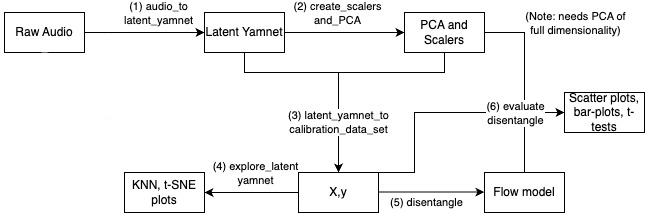

The analysis consists of multiple steps which involve the mapping of sounds from their acoustic representation to a latent Yamnet one, the classification of these latent representations as well as the disentanglement of material and action factors. The above diagram illustrates the full analysis plan. When it comes to creating PCA models and scalers to project the latent Yamnet representations to a more manageable dimensionality, there are two options.
- The first option is to compute the small PCA models, meaning they are only used in the forward direction, e.g. from several thousand latent yamnet dimensions to 64 target dimensions. These are needed for all layers to run step 3 (latent_yamnet_to_calibraiton_data_set) and step 4 (expore_latent_yamnet) which visualizes the latent space in a 2D t-SNE projection and performs layer-wise material and action classification using KNN.
- By contrast, the complete PCA model that can also be used to map projected representations back to their original dimensionality requires a large amount of computing resources. It only makes sense to do it for layer 8, since here Yamnet's original dimensionality is sufficiently low to afford a complete PCA model. Also, these layers tend to represent materials and sounds of actions most strongly, which makes them best suited for disentanglement of these two factors. The evaluate_disentangle script (step 6) will take the flow model to disentangle sounds, e.g. of layer 8, then perturb their material (or action) value and use the complete PCA model of that layer to project the adjusted sounds back onto Yamnet's original layer 8 latent space. It then continues Yamnet's downward processing to study the effect of the perturbations on Yamnet's output classes.

Hence, if your final goal was to only run step 4 (explore_latent_yamnet), then you would only need to make sure you have your latent yamnet representations of all sounds and the small PCA models and standard scalers for all Yamnet layers. However, if you wanted to do the causal experiments that involve perturbing action and material properties in Yamnet's layer 8, then you need to make sure you have the complete PCA model and its standard scalers for the layer of interest (step 2) and then run steps 3, 5 and 6.

The below sections guide you through the different analysis steps. You can visit each section upon interest. Watch out for the requirements of each section to see whether you need to have executed a prior section beforehand. You will see that the code snippets always just call existing functions defined in the `LatentAudio/scripts folder` of our code repository. Feel free to adjust these scripts to your needs.

### Configuration
Before starting the analysis, it makes sense to set a few configuration parameters and save them to a file. We prepared a simple configuration for you using the below code cell and saved it to `LatentAudio/configurations/Simple Configuration.json`. You can see in the file `LatentAudio/configurations/selected.txt` that this simple configuration is the one that is chosen by default. The subsequent scripts that execute the analysis will use this simple configuration. This will result in a shortened version of the analysis from our accompanying paper that will demonstrate the highlights of our analysis with minimal time and storage requirements. We also provide the `From Paper Configuration.json` which will give you the same analysis as we present in our paper. To use it, change the content of `LatentAudio/configurations/selected.txt` to 'configuration_from_paper'. If you want to experiment with your own configuration, use the below code cell to create one. Make sure to assign it a descriptive name.

In [ ]:
import os
import json

# Set parameters
configuration_name = 'simple configuration'
random_seed = 42
project_folder = ['LatentAudio'] # Your terminal/ code editor is likley pointing to the latent audio folder right now. You can leave it like this for the time being. However, if you want to use your own data or models, you might want to set this path variable to a more convenient folder, here.
external_hard_drive_path = project_folder # After concatenation, this gives a path to a folder that is used to store all (intermediate and final) results of the analysis. If you have an external hard-drive, we recommend to set this path to a folder on that hard-drive. If you are on Google Colab, the session storage should be sufficient. But. remember that it will get deletd once your Colab runtime is destroyed.
layer_indices = [0,9,13]
material_to_index = {"W":0,"G":1,"P":2,"S":3,"C":4}
action_to_index = {"T":0,"R":1,"W":2}
stage_count = 3 # Determines the size of the flow model
epoch_count = 100 # Determines the number of epochs for training the flow model


configuration = {
  # Configuration
  'name': configuration_name,
  'steps' : [
    {
      'script' : 'audio_to_latent_yamnet',
      'arguments' :
      {
      'sounds_folder': project_folder + ['data','sounds','complete'],
      'sound_file_names': [f"{m}{a}.wav" for m in material_to_index.keys() for a in action_to_index.keys()], # Ensuring the only process the sound files for the selected materials and actions (efficiency)
      'latent_representations_folder': external_hard_drive_path + [configuration_name,'data','latent','original'],# Will store the original and projected latent yamnet representations for each layer for each sound. Since this requires tens of gigabytes, you might want to direct this to an external hard-drive.
      'layer_indices': layer_indices,
      'time_frames_per_slice': 10,
      'offset': 1,
      'figure_folder': external_hard_drive_path + [configuration_name,'figures']
      }
    },
    {
      'script' : 'create_scalers_and_PCA_model_for_latent_yamnet',
      'arguments' :
      {
      'latent_representations_folder': external_hard_drive_path + [configuration_name,'data','latent','original'],
      'PCA_and_standard_scaler_folder': external_hard_drive_path + [configuration_name,'models','pca and standard scalers'],
      'layer_indices': [8],
      'target_dimensionalities': [None], # None means a full PCA model
      'random_seeds': [random_seed] * len(layer_indices), # Each layer gets its own seed, for simplicity, we set all equal
      'sample_sizes': [None] # None means that the sample size will be 1.1 * target dimensionality which gives 11246 for layer 8. Here, we set it to the same number for all other layers
      }
    },
    {
      'script' : 'apply_scalers_and_PCA_to_latent_yamnet',
      'arguments' :
      {
      'latent_representations_folder': external_hard_drive_path + [configuration_name,'data','latent','original'],
      'PCA_and_standard_scaler_folder': external_hard_drive_path + [configuration_name,'models','pca and standard scalers'],
      'layer_indices': [8],
      'target_dimensionalities': [64], # All should project to the same dimensionality now
      'projection_folder': external_hard_drive_path + [configuration_name,'data','latent','pca projected'],
      'file_name_prefix_to_factor_wise_label':  {f"{m}{a}" : [material_to_index[m], action_to_index[a]] for m in material_to_index.keys() for a in action_to_index.keys()}, # File names are of the form MA, where M is the material abbreviation and A the action abbreviation
      'figure_folder':  external_hard_drive_path + [configuration_name,'figures']
      }
    },
    {
      'script' : 'explore_latent_yamnet',
      'arguments' :
      {
      'pca_projected_folder': external_hard_drive_path + [configuration_name,'data','latent','pca projected'],
      'layer_indices': layer_indices,
      'random_seeds': [random_seed] * len(layer_indices),
      'sample_sizes': [3000] * len(layer_indices),
      'factor_name': 'Material',
      'factor_index': 0,
      'cross_validation_folds': 10,
      'neighbor_count': 10,
      'class_index_to_name': {value:key for key, value in material_to_index.items()},
      'figure_folder':  external_hard_drive_path + [configuration_name,'figures']
      }
    },
    {
      'script' : 'explore_latent_yamnet',
      'arguments' :
      {
      'pca_projected_folder': external_hard_drive_path + [configuration_name,'data','latent','pca projected'],
      'layer_indices': layer_indices,
      'random_seeds': [random_seed] * len(layer_indices),
      'sample_sizes': [3000] * len(layer_indices),
      'factor_name': 'Action',
      'factor_index': 1,
      'cross_validation_folds': 10,
      'neighbor_count': 10,
      'class_index_to_name': {value:key for key, value in action_to_index.items()},
      'figure_folder':  external_hard_drive_path + [configuration_name,'figures']
      }
    },
    {
      'script' : 'disentangle',
      'arguments' :
      {
      'random_seed': random_seed,
      'stage_count': stage_count,
      'batch_size': 1024,
      'epoch_count': epoch_count,
      'learning_rate': 0.001,
      'validation_proportion': 0.3,
      'dimensions_per_factor': [62,1,1], # In order of residual factor, material factor, action factor
      'factor_index_to_included_class_indices': {0: list(material_to_index.values()), 1: list(action_to_index.values())},
      'pca_projected_folder': external_hard_drive_path + [configuration_name,'data','latent','pca projected','Layer 8'],
      'flow_model_folder': external_hard_drive_path + [configuration_name, str(random_seed), 'models','flow'],
      'figure_folder':  external_hard_drive_path + [configuration_name, str(random_seed), 'figures']
      }
    },
    {
      'script' : 'evaluate_disentangle',
      'arguments' :
      {
      'stage_count': stage_count,
      'epoch_count': epoch_count,
      'dimensions_per_factor': [62,1,1], # In order of residual factor, material factor, action factor
      'random_seed': random_seed,
      'validation_proportion': 0.3,
      'factor_index_to_z_tilde_dimension': {0:62, 1:63},
      'factor_index_to_y_dimension': {0:0, 1:1},
      'factor_index_to_included_class_indices_to_names': {0: {value: key for key, value in material_to_index.items()}, 1: {value: key for key, value in action_to_index.items()}},
      'factor_index_to_name': {0:'Material',1:'Action'},
      'latent_representations_folder': external_hard_drive_path + [configuration_name,'data','latent','original','Layer 8'],
      'layer_index': 8,
      'pca_projected_folder': external_hard_drive_path + [configuration_name,'data','latent','pca projected','Layer 8'],
      'PCA_and_standard_scaler_folder': external_hard_drive_path + [configuration_name,'models','pca and standard scalers','Layer 8'],
      'flow_model_folder': external_hard_drive_path + [configuration_name,(str)(random_seed), 'models','flow'],
      'figure_folder':  external_hard_drive_path + [configuration_name,(str)(random_seed), 'figures'],
      'file_name_prefix_to_factor_wise_label':  {f"{m}{a}" : [material_to_index[m], action_to_index[a]] for m in material_to_index.keys() for a in action_to_index.keys()}, # File names are of the form MA, where M is the material abbreviation and A the action abbreviation
      }
    }
  ],
}
# Write configuration to file
with open(os.path.join(*project_folder+['configurations', configuration['name'] + '.json']),'w') as f:
  json.dump(configuration,f)

### (1) Waveform to Latent Yamnet
**Description:** This step takes all sounds from the data set, ensures they are 5.28-second long snippets and passes them through Yamnet. Then, at each layer of Yamnet, it extracts the representations, flattens them and saves them to disk.

**Necessity:** This step is necessary such that we can explore the latent representations with PCA, t-SNE and KNN (step 4) as well as disentangle and manipulate them (steps 5 and 6).

**Time:** This step took approximately 1 hour, in our Google Colab test on the raw data (i.e. without augmentation).

**Memory:** This step requires less than 12GB RAM.

**Storage:** This step produces ca. 46GB of storage in case of using only the raw data (i.e. without augmentation).

**Pre-requisites:**
- You need to have a set of sounds that are recorded according to a fully factorized design. Here, we use the two factors material and action. Our materials are  plastic, cardboard, glass, wood and stone and our actions are hitting, rubbing and whirling. This yields 5 material x 3 action = 15 conditions. For each condition, we recorded 10 minutes of continuous, monaural sound at 16kHz with int16 bit rate. The sound files are located in 'data/raw audio' and stored as .wav files whose file names consist of the initial letters of the corresponding material and action. You can use our data that was automatically downloaded with this repository. If you prefer, you can use your own data instead, but make sure to use the same format.

**Code Execution:** The below code navigates to the corresponding script, calls it with the -h argument to show how it is used and then uses it in conjunction with the our configuration file.

- *Local Machine:* Execute the below commands in your terminal. Note, on Unix-based systems you might need to replace the \ with a /
    ```
    python LatentAudio\scripts\audio_to_latent_yamnet.py -h
    python LatentAudio\scripts\audio_to_latent_yamnet.py --configuration_file_path 'LatentAudio\configurations\simple' --configuration_step 0
    ```

- *Colab:* Execute the below code cell.

In [ ]:
# Run the data audio to latent yamnet script
%%shell
eval "$(conda shell.bash hook)"
conda activate latent_audio_env

# See how to use the script
python LatentAudio/scripts/audio_to_latent_yamnet.py -h

# Use the script with the simple configuration
python LatentAudio/scripts/audio_to_latent_yamnet.py --configuration_file_path 'LatentAudio\configurations\simple' --configuration_step 0

### (2) Fitting Principal Component Models and Standard Scalers
**Description:** In order to analyze the latent representations of Yamnet, we decided to project them to a more manageable dimensionality with the help of principal component analysis (PCA). PCA assumes that the original dimensions are all on the same scale, hence we fit a pre-PCA standard scaler. After projecting the data, we also use a post-PCA standard scaler to make sure also the projections are on a standard scale which helps with downstream modelling. In the current step, we simply save these standard scalers and PCA models to disk. The actual scaling and projection of the data will be performed in step 3.

**Necessity:** This step is necessary to reduce the computational overload of steps 3, 4, 5 and 6.

**Time:** This step took ca. 30 minutes in our Google Colab test. Of these 30 minutes, ca 10 were devoted to creating small PCA models and standard scalers for all Yamnet layers except layer 1 (0 index-based) which would require too much memory (see below). The remaining 20 minutes were spent on creating 1 large PCA model and standard scalers for layer 8.

**Memory:** With our here provided configuration, this step required less than 12 GB of RAM. This covers setting up small PCA models and standard scalers for all Yamnet layers except layer 1 (0 index-based) as well as a large PCA model and standard scalers for layer 8. In separate tests on our local computer with 16GB RAM we were able to create an additional small PCA model and standard scalers also for layer 1.

**Storage:** With out here provided configuration (skipping layer 1), this step created a total of 0.68 GB of storage. Of these 0.68 GB, ca. 0.08 GB of storage were used for the small PCA models and standard scalers and the remaining ca. 0.6 GB of storage for the large PCA model and standard scaler for layer 8. On Google Colab, you will probably get a warning that you are approaching the storage limit. You can ignore this warning.

**Pre-requisites:** The layerwise Yamnet representations of sound need to be available (see step 1).

**Important technical note:** The process of fitting a PCA model to data is fast when the output dimensionality of PCA is small. This will suffice for most layers, namely those for which we do visualization (step 4 and parts of steps 5 and 6). Yet, when it comes to making perturbations to the disentangled latent space and measuring their effect on Yamnet's classification, we need PCA to be invertible. This only works if we have a PCA model of complete dimensionality, meaning same input as output dimensionality. Since it takes a large amount of time to fit such a PCA model, we decided to do this only for the Yamnet layer that best distinguishes materials and actions (as determined in step 4). For us, this was typically layer 8 and thus we show results for that layer in the paper. We observed slight variations depending on the sampling procedure with which data points are selected to be fed into our modelling pipeline. In the below code, we use layer 8 since that seemed best according to the exploratory analysis (step 4, see below).

**Interpretation of Results:** The current step also produces a few plots. The first plot shows for each layer the distribution of the proportion of explained variance across the projected number of dimensions (see configuration['PCA_target_dimensionality']). Each section in a bar corresponds to one such dimension. The dimensions are ordered by their respective proportions. The second plot shows how many dimensions each layer of the original Yamnet model had. You will see that only the layers of configuration['layer_indices_small_PCA'] and configuration['layer_index_full_PCA'] are included.

*Local Machine:* Run the script LatentAudio/scripts/create_scalers_and_PCA_model_for_latent_yamnet.py --configuration_file_path 'LatentAudio\configurations\simple' --configuration_step 1

*Colab:* Execute the below cell

In [ ]:
# Run the create_scalers_and_PCA_model_for_latent_yamnet script
%%shell
eval "$(conda shell.bash hook)"
conda activate latent_audio_env

python LatentAudio/scripts/create_scalers_and_PCA_model_for_latent_yamnet.py --configuration_file_path 'LatentAudio\configurations\simple' --configuration_step 1

### (3) Prepare projections of latent Yamnet for model training
**Description:** In this step, the latent representations of the individual sounds output by step 1 will be passed through the standard scalers and PCA from step 2 and saved into one unified matrix of shape [instance count, projected dimensionality] stored as X.npy. Next to that, a file called Y.npy will be created that is a matrix of shape [instance count, factor count], collecting the corresponding factor-wise label indices. Note, the output files will overwrite any existing files of same name at the given path (if existent).

**Necessity:** This step is necessary to calibrate the different models of steps 4 (t-SNE, KNN) and 5 (disentangling flow model) as well as to run the statistical tests in step 6.

**Time:** This step took ca. 75 minutes in our test on Google Colab that excluded layer 1 and used no data augmentation.

**Memory:** This step required us less than 12 GB of memory if layer 1 was excluded and no data augmentation was used.

**Storage:** This step produced ca 0.1 GB of storage, if layer 1 was excluded and no data was augmented.

**Pre-requisites:** It is assumed that the layer-wise latent Yamnet representations (step 1) as well as the standard scalers and small PCA models (step 2) for the layers at configuration['layer_indices_small_PCA'] and configuration['layer_index_large_PCA'] are available.

**Important technical note:** Most layers will be projected with the small PCA models and standard scalers. Only the layer that shall be disentangled in step 5 and 6 will be projected with the large PCA model because that one is the only invertible one.

*Local Machine:* Run the script LatentAudio/scripts/latent_yamnet_to_calibration_data_set.py --configuration_file_path 'LatentAudio\configurations\simple' --configuration_step 2

*Colab:* Execute the below cell


In [ ]:
# Run the latent_yamnet_to_calibration_data_set script
%%shell
eval "$(conda shell.bash hook)"
conda activate latent_audio_env

python LatentAudio/scripts/latent_yamnet_to_calibration_data_set.py --configuration_file_path 'LatentAudio\configurations\simple' --configuration_step 2

Now, the pre-processing is completed. The only data structures needed from here on are
- The latent Yamnet projected X and their Y matrices (all layers)
- The original x and y files of latent representations of sounds (only for layer with full PCA)
- The full dimensionality scalers and PCA models

All other files are no longer needed for the subsequent processing and may be deleted to save storage.

### (4) Explore latent Yamnet
**Description:** This step loads the layerwise latent yamnet projections from step 3, fits a cross-validated k-nearest neighbor model to each to predict materials and actions and creates a 2D projection for the first, most accurate and last layers using t-distributed stochastic neighborhood embeddings (t-SNE).
All created plots are saved at the figure output folder, where they replace any existing plots of same name (if existent).

**Time:** This step took ca. 5 minutes in our Google Colab test run which excluded layer 1.

**Memory:** The memory required for this step is well below 12GB.

**Storage:** The storage required for this step is on the order of kb, since only a few figures are saved.

**Necessity:** This step is optional, yet recommended in order to better understand to what extent material and action properties are represented in Yamnet's latent space.

**Pre-requisites:** Assumes that the calibration data X.npy and Y.npy (step 3) are available.

**Technical note:** The previous discussion of technical notes indicated that for layer 1, no projection from original latent dimensionality to a lower, more manageable dimensionality could be made. This is of no concern here, because the below function automatically selects only the available projections found in the latent data folder. Another issue discussed above was that layer 8 would be projected with the full PCA model while other layers would be projected with a small PCA model. This is also of no concern here, because the current step only processes the existing projections. It is indifferent to how the projections were obtained. You should, nonetheless, be able to verify that the layer chosen for full PCA model allows for the most accurate recognition of material (and action) classes. This observation justifies our earlier selection of layer 8 as the only layer for which a full PCA model was afforded. If you find that layer 9 is most accurate in the below outputs, do not be too concerned. The overall conclusions here as well as in later steps will remain the same. So, you can safely continue with your full PCA model for layer 8 from here on, rather than rebuilding the full PCA model for layer 9.

**Interpretation of Results:** The below cell will produce several results for the material factor as well as the action factor. After fitting the KNN models in a k-fold cross-validation procedure for each available layer, it will check which one is the most accurate. It will then perform 3 statistical tests (t-tests), to determine whether the first layer, the most accurate and the last layer are each significantly different in terms of KNN classification accuracy. We typically observe that layer 8 (or sometimes layer 9, depending on some random aspects of instance selection) allows for most accurate recognition of material classes. Similarly for action classes. After showing the statistical test results, the function will also create box plots for the cross-validated accuracies and indicate the statistically tested pairs of layers with horizontal lines. A star above the line indicates significance at the 5% Bonferroni corrected level. Lastly, the function plots the t-SNE projections onto 2 arbitrary spatial dimensions for the first, most accurate and last layers with coloring according to the corresponding factor's classes. Here, we typically found that small pockets of similar instances are most pronounced in the most accurate layer. This is merely a visual sanity check to convince ourselves that, indeed, the corresponding material (or action) classes are present in the layer of interest.

*Local Machine:* Run the scripts
- LatentAudio/scripts/explore_latent_yamnet.py --configuration_file_path 'LatentAudio\configurations\simple' --configuration_step 3
- LatentAudio/scripts/explore_latent_yamnet.py --configuration_file_path 'LatentAudio\configurations\simple' --configuration_step 4

*Colab:* Execute the below cell

In [ ]:
# Run the explore_latent_yamnet script
%%shell
eval "$(conda shell.bash hook)"
conda activate latent_audio_env

python LatentAudio/scripts/explore_latent_yamnet.py --configuration_file_path 'LatentAudio\configurations\simple' --configuration_step 3
python LatentAudio/scripts/explore_latent_yamnet.py --configuration_file_path 'LatentAudio\configurations\simple' --configuration_step 4

### (5) Disentangle Latent Yamnet
**Description:** In this step, a flow model is calibrated on the projected latent represenetations to disentangle the underlying factors (material and action). Each factor shall be separated into their respective classes, independent of the other factor. Several plots are created to illustrate the process. The plots will overwrite any existing plots of same name.

**Pre-requisites:** It is assumed that the calibration data set consisting of projected latent yamnet representations for the layer with full PCA was created apriori.

**Time:** This step took us ca. 30 minutes for layer 8 run on the raw data (thus no augmentation). Yet, this may vary depending on how long you want to calibrate the model.

**Memory:** This step requires less than 12GB of RAM.

**Storage:** This step requires little storage, on the order of MB, and varies depending on how large you choose the model to be.

*Local Machine:* Run the script LatentAudio/scripts/disentangle.py --configuration_file_path 'LatentAudio\configurations\simple' --configuration_step 5

*Colab:* Execute the below cell

In [ ]:
# Run the disentangle script
%%shell
eval "$(conda shell.bash hook)"
conda activate latent_audio_env

python LatentAudio/scripts/disentangle.py --configuration_file_path 'LatentAudio\configurations\simple' --configuration_step 5

### (6) Evaluate Disentanglement
**Description:** In this step, the disentangling flow model from step 5 is evaluated. This is done in two steps. The first step passes some latent Yamnet projections through the flow model and shows the first two dimensions of the disentangled space in a scatter plot. These two dimensions correspond to the material and action variation, respectively. All remaining dimensions are not shown, yet they are knwon to only represent uniformly distributed residual variance of the sounds. The second step permutes sounds along the material axis (or action axis) and uses the invertibility of the flow model and the full PCA model to map them back onto Yamnet's latent space. Downstream Yamnet processing is then executed to illustrate the effect on its classification.

**Time:** This step takes ca. 10 minutes.

**Memory:** This step requires much less than the 12 GB RAM of Google Colab.

**Storage:** This step requires very little storage, on the order of kb, since only figures are stored.

*Local Machine:* Run the script LatentAudio/scripts/evaluate_disentangle.py --configuration_file_path 'LatentAudio\configurations\simple' --configuration_step 6

*Colab:* Execute the below cell

In [ ]:
# Run the evaluate disentangle script
%%shell
eval "$(conda shell.bash hook)"
conda activate latent_audio_env

python LatentAudio/scripts/evaluate_disentangle.py --configuration_file_path 'LatentAudio\configurations\simple' --configuration_step 6

### Complete Configuration

If you aim to replicate our work from the paper, use the below complete configuration. It uses the whole dataset (3x as large as the short set from before) and performs its calculates for all layers (except for the flow modeling).

In [ ]:
import os
import json

# Set parameters
configuration_name = 'complete configuration'
random_seed = 42
project_folder = ['LatentAudio'] # Your terminal/ code editor is likley pointing to the latent audio folder right now. You can leave it like this for the time being. However, if you want to use your own data or models, you might want to set this path variable to a more convenient folder, here.
external_hard_drive_path = [r'D:\\'] + project_folder # After concatenation, this gives a path to a folder that is used to store all (intermediate and final) results of the analysis. It will require up to 60 GB. If you have an external hard-drive, we recommend to set this path to a folder on that hard-drive. If you are on Google Colab, the session storage should be sufficient. But. remember that it will get deletd once your Colab runtime is destroyed.
layer_indices = list(range(14))
material_to_index = {"W":0,"G":1,"P":2,"S":3,"C":4}
action_to_index = {"T":0,"R":1,"W":2}
stage_count = 3
epoch_count = 100

configuration = {
  # Configuration
  'name': configuration_name,
  'steps' : [
    {
      'script' : 'audio_to_latent_yamnet',
      'arguments' :
      {
      'sounds_folder': project_folder + ['data','sounds','complete'],
      'sound_file_names': [f"{m}{a}.wav" for m in material_to_index.keys() for a in action_to_index.keys()], # Ensuring the only process the sound files for the selected materials and actions (efficiency)
      'latent_representations_folder': external_hard_drive_path + [configuration_name,'data','latent','original'],# Will store the original and projected latent yamnet representations for each layer for each sound. Since this requires tens of gigabytes, you might want to direct this to an external hard-drive.
      'layer_indices': layer_indices,
      'time_frames_per_slice': 10,
      'offset': 1,
      'figure_folder': external_hard_drive_path + [configuration_name,'figures']
      }
    },
    {
      'script' : 'create_scalers_and_PCA_model_for_latent_yamnet',
      'arguments' :
      {
      'latent_representations_folder': external_hard_drive_path + [configuration_name,'data','latent','original'],
      'PCA_and_standard_scaler_folder': external_hard_drive_path + [configuration_name,'models','pca and standard scalers'],
      'layer_indices': [8],
      'target_dimensionalities': [None], # None means a full PCA model
      'random_seeds': [random_seed] * len(layer_indices), # Each layer gets its own seed, for simplicity, we set all equal
      'sample_sizes': [None] # None means that the samples ize will be 1.1 * target dimensionality which gives 11246 for layer 8. Here, we set it to the same number for all other layers
      }
    },
    {
      'script' : 'apply_scalers_and_PCA_to_latent_yamnet',
      'arguments' :
      {
      'latent_representations_folder': external_hard_drive_path + [configuration_name,'data','latent','original'],
      'PCA_and_standard_scaler_folder': external_hard_drive_path + [configuration_name,'models','pca and standard scalers'],
      'layer_indices': [8],
      'target_dimensionalities': [64], # All should project to the same dimensionality now
      'projection_folder': external_hard_drive_path + [configuration_name,'data','latent','pca projected'],
      'file_name_prefix_to_factor_wise_label':  {f"{m}{a}" : [material_to_index[m], action_to_index[a]] for m in material_to_index.keys() for a in action_to_index.keys()}, # File names are of the form MA, where M is the material abbreviation and A the action abbreviation
      'figure_folder':  external_hard_drive_path + [configuration_name,'figures']
      }
    },
    {
      'script' : 'explore_latent_yamnet',
      'arguments' :
      {
      'pca_projected_folder': external_hard_drive_path + [configuration_name,'data','latent','pca projected'],
      'layer_indices': layer_indices,
      'random_seeds': [random_seed] * len(layer_indices),
      'sample_sizes': [3000] * len(layer_indices),
      'factor_name': 'Material',
      'factor_index': 0,
      'cross_validation_folds': 10,
      'neighbor_count': 10,
      'class_index_to_name': {value:key for key, value in material_to_index.items()},
      'figure_folder':  external_hard_drive_path + [configuration_name,'figures']
      }
    },
    {
      'script' : 'explore_latent_yamnet',
      'arguments' :
      {
      'pca_projected_folder': external_hard_drive_path + [configuration_name,'data','latent','pca projected'],
      'layer_indices': layer_indices,
      'random_seeds': [random_seed] * len(layer_indices),
      'sample_sizes': [3000] * len(layer_indices),
      'factor_name': 'Action',
      'factor_index': 1,
      'cross_validation_folds': 10,
      'neighbor_count': 10,
      'class_index_to_name': {value:key for key, value in action_to_index.items()},
      'figure_folder':  external_hard_drive_path + [configuration_name,'figures']
      }
    },
    {
      'script' : 'disentangle',
      'arguments' :
      {
      'random_seed': random_seed,
      'stage_count': stage_count,
      'batch_size': 1024,
      'epoch_count': epoch_count,
      'learning_rate': 0.001,
      'validation_proportion': 0.3,
      'dimensions_per_factor': [62,1,1], # In order of residual factor, material factor, action factor
      'factor_index_to_included_class_indices': {0: list(material_to_index.values()), 1: list(action_to_index.values())},
      'pca_projected_folder': external_hard_drive_path + [configuration_name,'data','latent','pca projected','Layer 8'],
      'flow_model_folder': external_hard_drive_path + [configuration_name, str(random_seed), 'models','flow'],
      'figure_folder':  external_hard_drive_path + [configuration_name, str(random_seed), 'figures']
      }
    },
    {
      'script' : 'evaluate_disentangle',
      'arguments' :
      {
      'stage_count': stage_count,
      'epoch_count': epoch_count,
      'dimensions_per_factor': [62,1,1], # In order of residual factor, material factor, action factor
      'random_seed': random_seed,
      'validation_proportion': 0.3,
      'factor_index_to_z_tilde_dimension': {0:62, 1:63},
      'factor_index_to_y_dimension': {0:0, 1:1},
      'factor_index_to_included_class_indices_to_names': {0: {value: key for key, value in material_to_index.items()}, 1: {value: key for key, value in action_to_index.items()}},
      'factor_index_to_name': {0:'Material',1:'Action'},
      'latent_representations_folder': external_hard_drive_path + [configuration_name,'data','latent','original','Layer 8'],
      'layer_index': 8,
      'pca_projected_folder': external_hard_drive_path + [configuration_name,'data','latent','pca projected','Layer 8'],
      'PCA_and_standard_scaler_folder': external_hard_drive_path + [configuration_name,'models','pca and standard scalers','Layer 8'],
      'flow_model_folder': external_hard_drive_path + [configuration_name,(str)(random_seed), 'models','flow'],
      'figure_folder':  external_hard_drive_path + [configuration_name,(str)(random_seed), 'figures'],
      'file_name_prefix_to_factor_wise_label':  {f"{m}{a}" : [material_to_index[m], action_to_index[a]] for m in material_to_index.keys() for a in action_to_index.keys()}, # File names are of the form MA, where M is the material abbreviation and A the action abbreviation
      'swop_to_sample_size': {"Material": 96, "Action": 50, "Material and Action": 49} # This is the sample size used for a paired samples t-test in the latent transfer to compare Yamnet's output distances before and after transfer
      }
    }
  ],
}
# Write configuration to file
with open(os.path.join(*project_folder+['configurations', configuration['name'] + '.json']),'w') as f:
  json.dump(configuration,f)